In [1]:
from feature_engineering import create_features
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
from joblib import dump, load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
)
from sklearn.preprocessing import LabelEncoder


In [2]:
best_model = load('/work/best_model.pkl')
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.61137546612658,
              colsample_bynode=0.6680329695070676,
              colsample_bytree=0.6756812888236807, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=3.707511314974085e-05, eval_metric=None, feature_types=None,
              gamma=9.27135012578741e-08, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.013934044662060332, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=5,
              max_depth=8, max_leaves=417, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=943,
              n_jobs=None, num_parallel_tree=None, ...)

In [3]:

train = pd.read_csv("merged_dataset.csv")
train = create_features(train)
X = train.drop(["NObeyesdad", "id"], axis=1)
y = train["NObeyesdad"]

categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
numerical_cols = [
    cname for cname in X.columns if X[cname].dtype in ["int64", "float64"]
]

numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_model)])
le = LabelEncoder()
y_encoded = le.fit_transform(y)
my_pipeline.fit(X, y_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CAEC',
                                                   'CH2O', 'FAF', 'TUE',
                                                   'log_BMI',
                                                   'physical_activity_score',
                                                   'caloric_intake_tendency',
                                                   'healthy_eating_score',
                                                   'BMR',
                                                   'meal_regularity_score',
                                                   'snacking_habit',
                                                   'stress_e...
                               feature_types=None, gamma=9.27135012578741e-08,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.013934044662060332, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=5, max_depth=8, max_leaves=417,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=943, n_jobs=None,
                               num_parallel_tree=None, ...))])

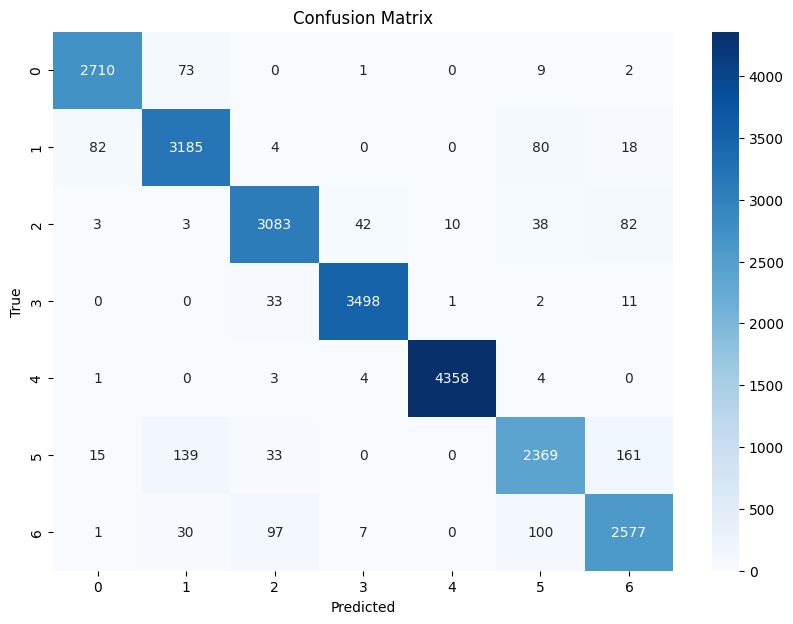

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.97      0.97      2795
      Normal_Weight       0.93      0.95      0.94      3369
     Obesity_Type_I       0.95      0.95      0.95      3261
    Obesity_Type_II       0.98      0.99      0.99      3545
   Obesity_Type_III       1.00      1.00      1.00      4370
 Overweight_Level_I       0.91      0.87      0.89      2717
Overweight_Level_II       0.90      0.92      0.91      2812

           accuracy                           0.95     22869
          macro avg       0.95      0.95      0.95     22869
       weighted avg       0.95      0.95      0.95     22869



In [4]:
y_train_pred = my_pipeline.predict(X)

cm = confusion_matrix(y_encoded, y_train_pred)
plt.figure(figsize=(10,7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

report = classification_report(y_encoded, y_train_pred, target_names=le.classes_)
print(report)

In [5]:
from joblib import dump
dump(my_pipeline, 'trained_pipeline.pkl')

['trained_pipeline.pkl']

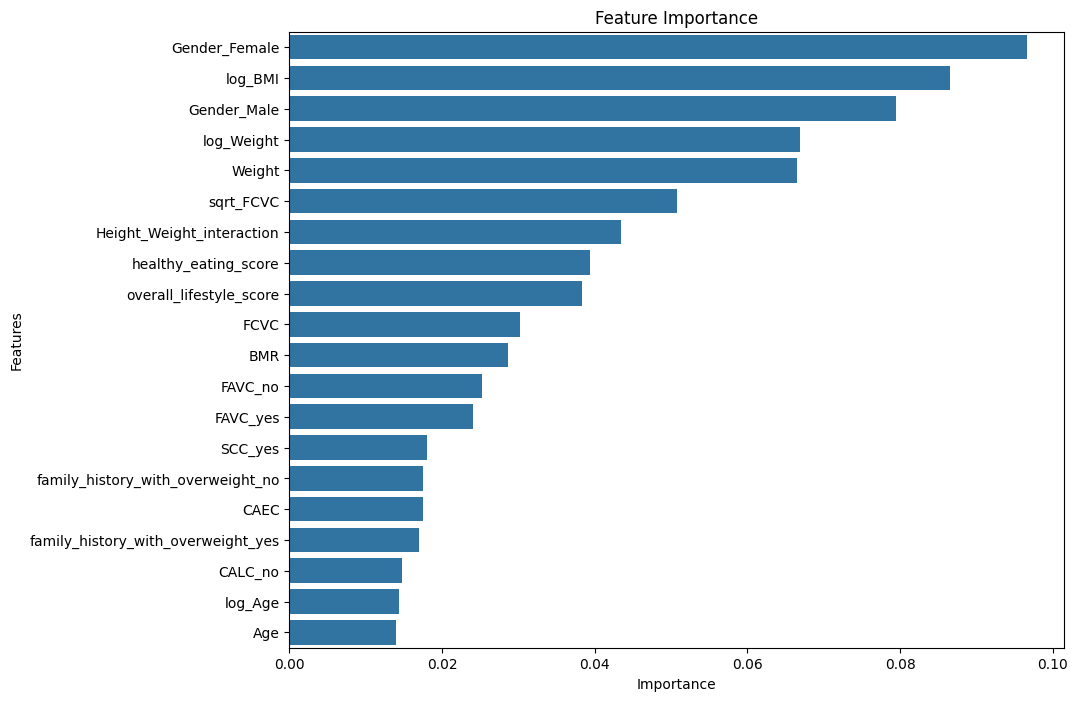

In [6]:
feature_importance = best_model.feature_importances_
feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, feature_names])
feature_imp_df = pd.DataFrame({'Features': feature_names, 'Importance': feature_importance})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Features", data=feature_imp_df.head(20))
plt.title('Feature Importance')
plt.show()

The most influential features in predicting obesity risk, based on our trained pipeline model, are:

1. Gender_Female: with an importance score of 0.096673
2. log_BMI: with an importance score of 0.086539
3. Gender_Male: with an importance score of 0.079466
4. log_Weight: with an importance score of 0.066843
5. Weight: with an importance score of 0.066523.

These are the top five most influential features. Other features with notable influence include `sqrt_FCVC`, `Height_Weight_interaction`, `healthy_eating_score`, `overall_lifestyle_score` and `FCVC`.

On the contrary, `CALC_Always`, `MTRANS_Bike`, and `MTRANS_Motorbike` appear to have no significant importance in predicting obesity risk based on the current dataset and model.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
my_pipeline.fit(X_train, y_train)
train_score = my_pipeline.score(X_train, y_train)
test_score = my_pipeline.score(X_test, y_test)

(train_score, test_score)

(0.9545230937414594, 0.9112374289462177)

The trained pipeline performs well on both the training and the testing parts of the dataset. It has an accuracy of approximately 95.45% on the training data and 91.12% on the testing data.

In [8]:
y_pred = my_pipeline.predict_proba(X_test)

from sklearn.metrics import roc_curve, roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(le.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:, i], pos_label=i)
    roc_auc[i] = roc_auc_score(y_test == i, y_pred[:, i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = roc_auc_score(y_test, y_pred, multi_class="ovr")

roc_auc

{0: 0.9961398250871933,
 1: 0.9898394119551022,
 2: 0.990621911013513,
 3: 0.9985083850545072,
 4: 0.9999525119152637,
 5: 0.9801433233210962,
 6: 0.985541094140315,
 'macro': 0.9915352089267129}

The AUC scores for each class and the overall multi-class AUC score for the model predictions are as follows:

- Class 0 (Insufficient Weight): 0.9961
- Class 1 (Normal Weight): 0.9898
- Class 2 (Obesity Type I): 0.9906
- Class 3 (Obesity Type II): 0.9985
- Class 4 (Obesity Type III): 0.9999
- Class 5 (Overweight Level I): 0.9801
- Class 6 (Overweight Level II): 0.9855
- Overall multi-class AUC: 0.9915

These scores indicate that the trained pipeline model has a high predictive ability for all obesity classes. An AUC score of 1 is considered perfect, and values above 0.90 are generally considered excellent.

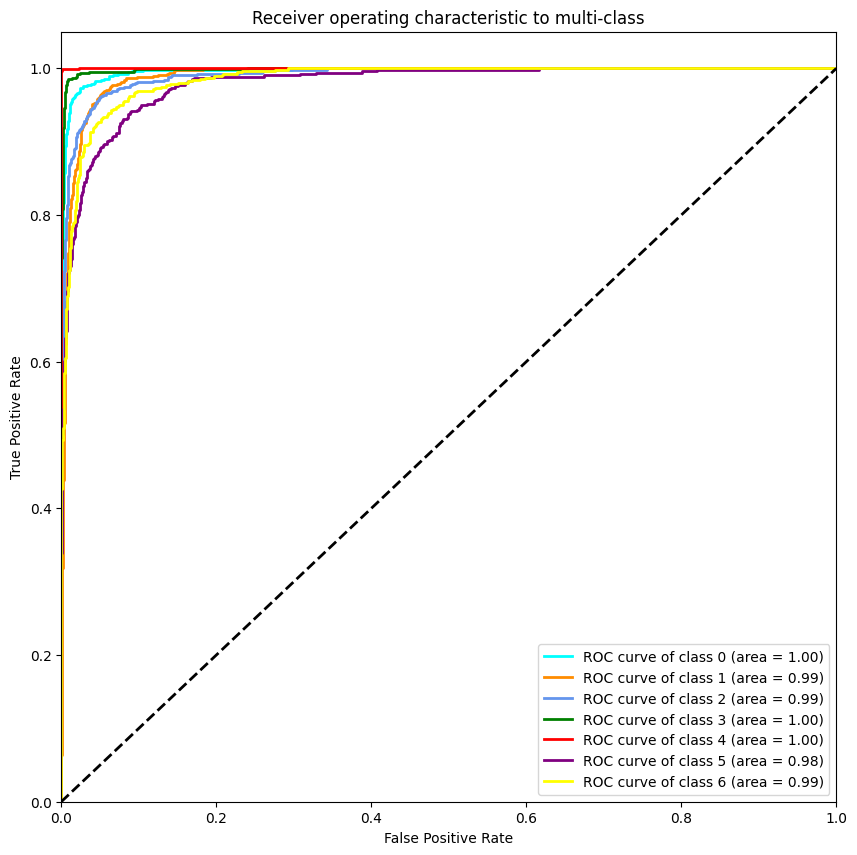

In [9]:
from itertools import cycle

plt.figure(figsize=(10,10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

The Receiver Operating Characteristic (ROC) curves for each class, along with their respective Area Under the Curve (AUC) scores, are plotted above. 

An excellent model has an AUC near to the 1 which means it has a good measure of separability. A poor model has AUC near to the 0 which means it has a worse measure of separability. In fact, it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means the model has no class separation capacity whatsoever.

From the above graph, we see that the AUC for our classes are within 0.98 to 1 which means the model is excellent for the prediction of obesity risk. The plot shows that the predictive performance of the model is strong across all classes, as indicated by the shape of the curves and their AUC scores. The closer the ROC curve is to the top left corner, the higher the model's predictive accuracy.

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


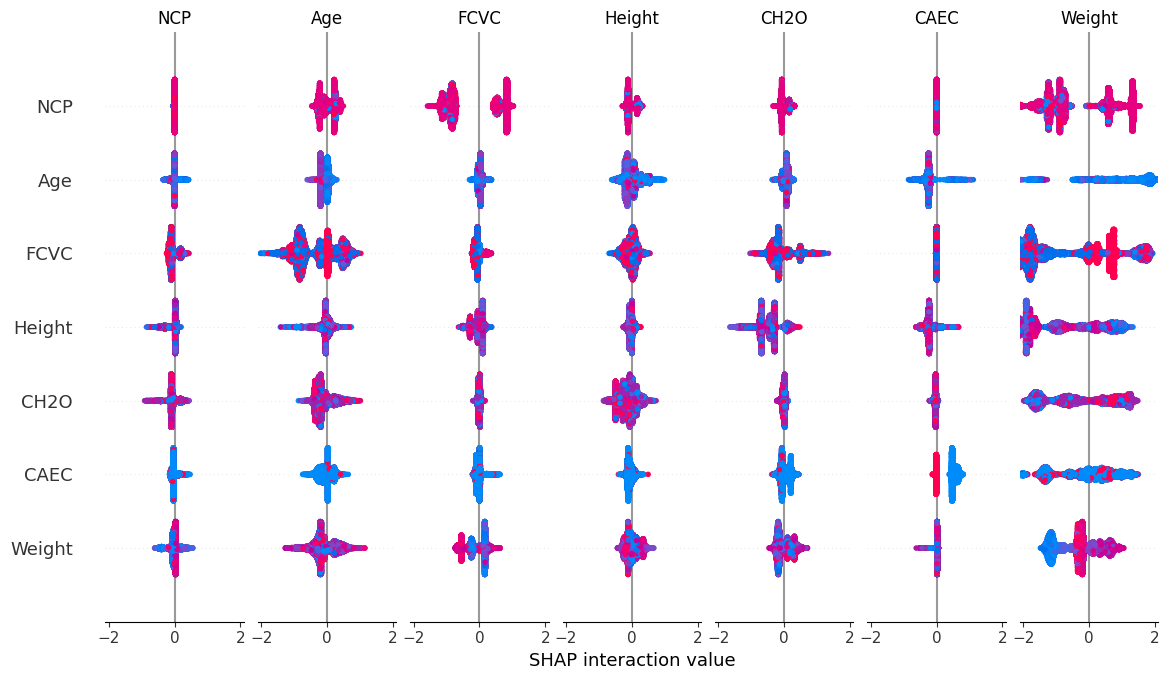

In [10]:
import shap
X_train = train.drop(["NObeyesdad", "id"], axis=1)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar", show=False)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8973d6a1-4867-433a-bd13-9dab8e184951' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>